# Exercise 5

With PyTorch, we can use the `torch.nn.Conv2d` class to perform (and learn) convolution over 2D input tensors, e.g. images.

In [1]:
import torch
import torch.nn as nn

in_channels = 3
out_channels = 2
filter_size = (3, 3)
conv1 = nn.Conv2d(in_channels, out_channels, filter_size)

In this notebook, we will not learn the weights in this convolutional module, but replace them with some well-known kernels. One is an edge-detection kernel, the other a blurring kernel.

In [2]:
edge_detection_kernel = 1.0/10 * torch.tensor([[ -1, -1, -1 ], [-1, 8, -1], [-1, -1, -1]], dtype=torch.float)
blur_kernel = 1.0/9 * torch.tensor([[ 1, 1, 1 ], [1, 1, 1], [1, 1, 1]], dtype=torch.float)

# We repeat the kernel for each of the three input channels, which has the effect of implicitly converting to grayscale
conv1.weight.data = torch.stack([
    1.0/3 * edge_detection_kernel.unsqueeze(0).repeat(3, 1, 1),
    1.0/3 * blur_kernel.unsqueeze(0).repeat(3, 1, 1)
])
conv1.bias.data = torch.tensor([128, 0], dtype=torch.float)

To test these kernels, we load an example image:

C:\Users\Khaled\AppData\Local\Temp\ipykernel_32520\1443223621.py:3: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  img = face()


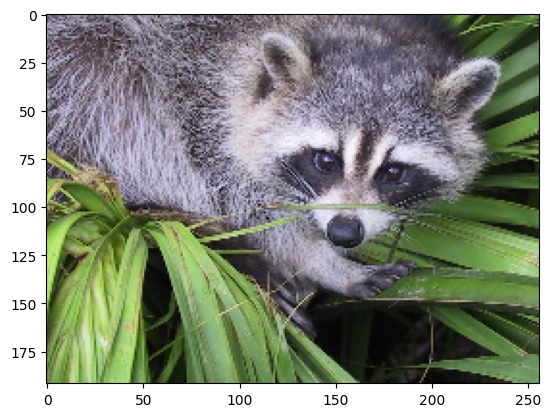

In [3]:
from scipy.misc import face

img = face()
img = img[::4, ::4] # scale-down image to decrease computation time

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(img, cmap='gray')
plt.show()

Now we can calculate the result of performing these convolutions on our test image:

In [4]:
img_torch = torch.as_tensor(img.copy(), dtype=torch.float)
img_torch = img_torch.permute(2, 0, 1).unsqueeze(0) # Permute dimensions to be channels-first, add one dimension for batch
print(img_torch.shape)

conv1_result = conv1(img_torch)
print(conv1_result.shape)

torch.Size([1, 3, 192, 256])
torch.Size([1, 2, 190, 254])


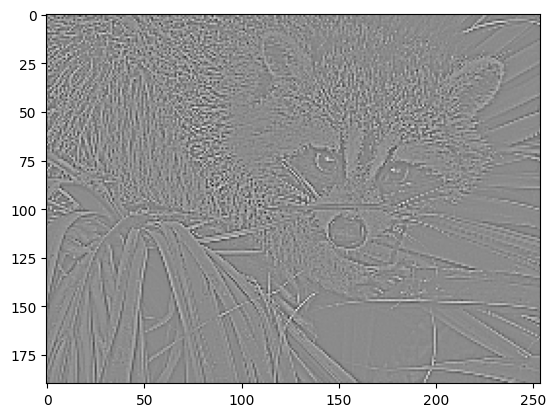

Image minimum value: 13.733347
Image maximum value: 223.86667


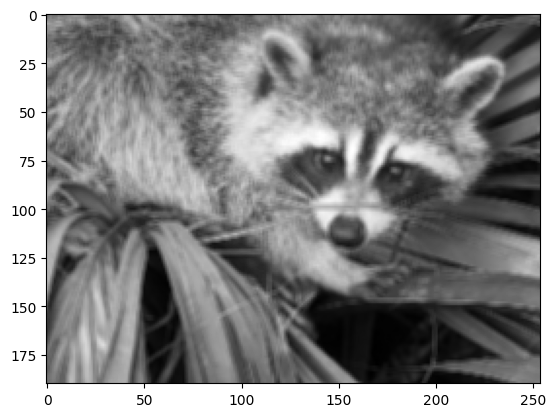

Image minimum value: 5.518518
Image maximum value: 248.25928


In [5]:
def disp_result(result):
    for channel in range(out_channels):
        res_img = result[0, channel].detach().numpy()
        plt.imshow(res_img, cmap='gray')
        plt.show()
        print("Image minimum value:", res_img.min())
        print("Image maximum value:", res_img.max())
        
disp_result(conv1_result)

As we can see, the result matches our expectations. The first kernel detects edges in the image, while the second kernel blurred the input image.

Your task in this network is to manually implement a class that performs the same operation as `Conv2d`. That is, it slides a weight tensor over the input image, performs element-wise multiplication between the weights and the matching region, and sums up the results (plus the bias). You can implement this with a few nested for-loops in the `forward()` method of the below class.

In [6]:
class ConvLayer2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ConvLayer2D, self).__init__()

        weight_shape = (out_channels, in_channels, *kernel_size)
        self.weight = nn.Parameter(torch.empty(weight_shape, requires_grad=True))
        self.bias = nn.Parameter(torch.empty(out_channels, requires_grad=True))
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        # we initialize the weights here, although they are overwritten later in this notebook.
        nn.init.kaiming_uniform_(self.weight.data)
        nn.init.zeros_(self.bias.data)

    def forward(self, x):
        assert x.shape[1] == self.in_channels, "Input channels do not match in_channels."
        batch_size, _, input_h, input_w = x.shape
        kernel_h, kernel_w = self.kernel_size
        output_h = input_h - kernel_h + 1
        output_w = input_w - kernel_w + 1

        # Prepare the output tensor
        result = torch.zeros(
            (batch_size, self.out_channels, output_h, output_w), device=x.device
        )

        # Perform convolution
        for b in range(batch_size):  # Iterate over the batch
            for c_out in range(self.out_channels):  # Iterate over the output channels
                for h in range(output_h):  # Iterate over the height of the output
                    for w in range(output_w):  # Iterate over the width of the output
                        for c_in in range(self.in_channels):  # Iterate over input channels
                            # Extract the region from the input
                            region = x[b, c_in, h:h+kernel_h, w:w+kernel_w]
                            # Perform element-wise multiplication and sum up
                            result[b, c_out, h, w] += torch.sum(
                                region * self.weight[c_out, c_in]
                            )
                        # Add the bias
                        result[b, c_out, h, w] += self.bias[c_out]

        return result

To test your implementation, you can run the below code to perform the convolution with your module. The result should be the same as with the pytorch `Conv2d` class.

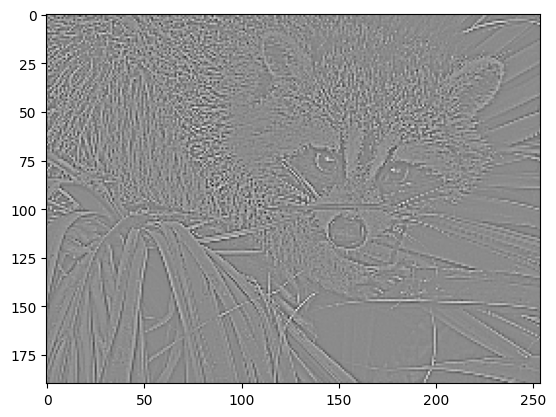

Image minimum value: 13.73333
Image maximum value: 223.86667


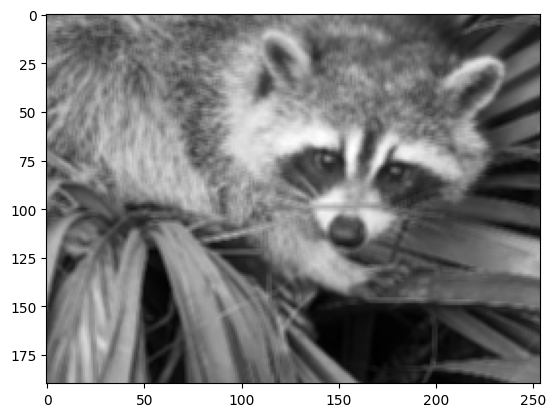

Image minimum value: 5.5185184
Image maximum value: 248.25925


In [7]:
conv2 = ConvLayer2D(in_channels, out_channels, filter_size)
conv2.weight.data = conv1.weight.data
conv2.bias.data = conv1.bias.data

conv2_result = conv2(img_torch)
disp_result(conv2_result)

assert(torch.allclose(conv1_result, conv2_result))